# Data visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from pyproj import Geod
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
df = pd.read_json('../data/car_log_20250504_132551_small_track_gt.jsonl', lines=True)
df_sim = pd.read_json('../data/simulations/car_log_transformerdql10_20250608_170413.jsonl', lines=True)
model_name = 'transformer10'

df.head(10)

,timestamp,speed_mps,yaw,steering_angle,latitude,longitude,altitude
0,63798,1.699987,0.0,0.0,55.944493,-3.186458,0.652514
1,63998,1.699987,0.0,0.0,55.944493,-3.186453,0.652514
2,64198,1.699987,0.0,0.0,55.944493,-3.186448,0.652513
3,64398,1.699987,0.0,0.0,55.944493,-3.186442,0.652513
4,64598,1.699987,0.0,0.0,55.944493,-3.186437,0.652512
5,64798,1.699987,0.0,0.0,55.944493,-3.186431,0.652512
6,64998,1.699987,0.0,0.0,55.944493,-3.186426,0.652511
7,65198,1.699987,0.0,0.0,55.944493,-3.186420,0.652511
8,65398,1.699987,0.0,0.0,55.944493,-3.186415,0.652510
9,65598,1.699987,0.0,0.0,55.944493,-3.186409,0.652510


In [3]:
df = df[df['speed_mps'] > 0]
df_sim = df_sim[df_sim['speed_mps'] > 0]

df.shape, df_sim.shape

((303, 7), (382, 7))

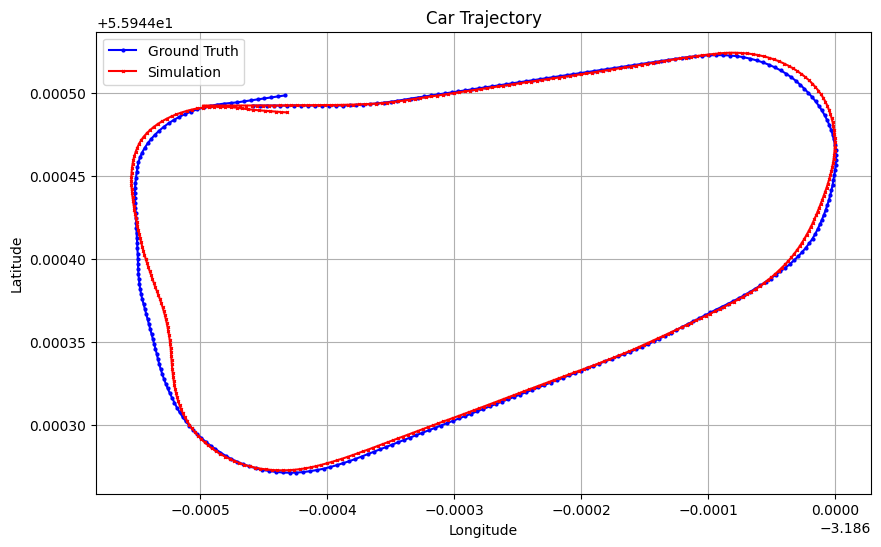

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df['longitude'], df['latitude'], marker='o', markersize=2, linestyle='-', label='Ground Truth', color='blue')
plt.plot(df_sim['longitude'], df_sim['latitude'], marker='x', markersize=2, linestyle='-', label='Simulation', color='red')
plt.title('Car Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()

In [5]:
# Remove the last entries
df = df.iloc[:-6]
df_sim = df_sim.iloc[:-12]

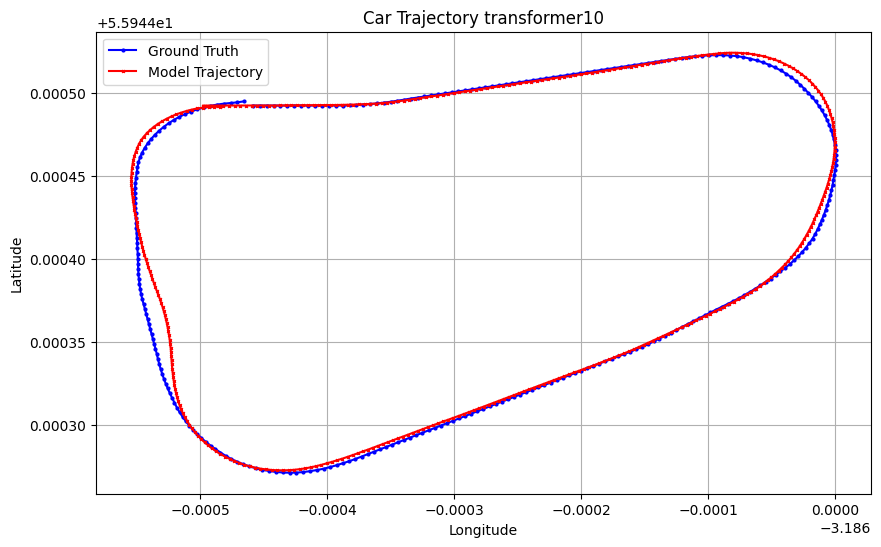

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(df['longitude'], df['latitude'], marker='o', markersize=2, linestyle='-', label='Ground Truth', color='blue')
plt.plot(df_sim['longitude'], df_sim['latitude'], marker='x', color='red', markersize=2, linestyle='-', label='Model Trajectory')

plt.title(f'Car Trajectory {model_name}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()

plot_path = f'../results/imgs/{model_name}.png'
plt.savefig(plot_path, dpi=300)

In [7]:
from scipy.spatial import KDTree

# Convert (longitude, latitude) to meters using a local tangent plane approximation
def lonlat_to_xy(lon, lat, ref_lon, ref_lat):
    # Approximate conversion using equirectangular projection
    R = 6371000  # Earth radius in meters
    x = (np.radians(lon) - np.radians(ref_lon)) * R * np.cos(np.radians(ref_lat))
    y = (np.radians(lat) - np.radians(ref_lat)) * R
    return np.stack([x, y], axis=-1)

# Reference point (first ground truth point)
ref_lon = df['longitude'].iloc[0]
ref_lat = df['latitude'].iloc[0]

ground_truth = lonlat_to_xy(df['longitude'].values, df['latitude'].values, ref_lon, ref_lat)
model_traj = lonlat_to_xy(df_sim['longitude'].values, df_sim['latitude'].values, ref_lon, ref_lat)

def point_to_segment_distance(pt, seg_start, seg_end):
    v = seg_end - seg_start
    w = pt - seg_start
    c1 = np.dot(w, v)
    c2 = np.dot(v, v)
    b = c1 / c2 if c2 != 0 else 0
    b = np.clip(b, 0, 1)
    pb = seg_start + b * v
    return np.linalg.norm(pt - pb)

def compute_lateral_errors(gt_path, model_path):
    errors = []
    for pt in model_path:
        min_dist = float('inf')
        for i in range(len(gt_path) - 1):
            seg_start = gt_path[i]
            seg_end = gt_path[i+1]
            dist = point_to_segment_distance(pt, seg_start, seg_end)
            min_dist = min(min_dist, dist)
        errors.append(min_dist)
    return np.array(errors)

lateral_errors = compute_lateral_errors(ground_truth, model_traj)
mean_error = np.mean(lateral_errors)
max_error = np.max(lateral_errors)
acc_error = np.sum(lateral_errors)

# RMSE
rmse = np.sqrt(np.mean(lateral_errors**2))

# Standard deviation of error
std_error = np.std(lateral_errors)

# Off-path rate (fraction of points with error > 0.5m)
off_path = np.sum(lateral_errors > 0.5) / len(lateral_errors)

# Area Between Curves (ABC) using the sum of lateral errors times the average step along the path
# Estimate step size along model trajectory
step_sizes = np.linalg.norm(np.diff(model_traj, axis=0), axis=1)
avg_step = np.mean(step_sizes)
abc = np.sum(lateral_errors) * avg_step

print(f"{'Mean lateral error:':30s} {mean_error:12.6f} m")
print(f"{'Max lateral error:':30s} {max_error:12.6f} m")
print(f"{'Acc lateral error:':30s} {acc_error:12.6f} m")
print(f"{'RMSE lateral error:':30s} {rmse:12.6f} m")
print(f"{'Std lateral error:':30s} {std_error:12.6f} m")
print(f"{'Off-path rate (>0.5m):':30s} {off_path:12.6} %")
print(f"{'Area Between Curves (ABC):':30s} {abc:12.6f} m^2")

Mean lateral error:                0.193620 m
Max lateral error:                 0.883544 m
Acc lateral error:                71.639248 m
RMSE lateral error:                0.280470 m
Std lateral error:                 0.202915 m
Off-path rate (>0.5m):            0.0864865 %
Area Between Curves (ABC):        19.824140 m^2


In [8]:
import os

metrics_data = {
    'Name': model_name,
    'Mean lateral error': float(mean_error),
    'Max lateral error': float(max_error),
    'Acc lateral error': float(acc_error),
    'RMSE lateral error': float(rmse),
    'Std lateral error': float(std_error),
    'Off-path rate (>0.5m)': float(off_path),
    'Area Between Curves (ABC)': float(abc)
}
df_current_metrics = pd.DataFrame(metrics_data, index=[model_name])

# Read from CSV if it exists, then add new metrics with a name column and save
csv_file = '../results/metrics.csv'
if os.path.exists(csv_file):
    df_metrics = pd.read_csv(csv_file)
    df_metrics = pd.concat([df_metrics, df_current_metrics], ignore_index=True)
else:
    df_metrics = df_current_metrics

df_metrics.to_csv(csv_file, index=False)

In [9]:
df_metrics = pd.read_csv('../results/metrics.csv')
df_metrics

,Name,Mean lateral error,Max lateral error,Acc lateral error,RMSE lateral error,Std lateral error,Off-path rate (>0.5m),Area Between Curves (ABC)
0,cnn,0.489371,2.443622,178.620355,0.774300,0.600048,0.312329,49.352711
1,lstm,0.460844,1.083329,168.208153,0.555954,0.310979,0.468493,46.434080
2,neural_network,0.676966,2.044782,256.570168,0.844024,0.504077,0.551451,70.563409
3,random_forest_1,1.818550,8.907357,745.605445,2.819297,2.154371,0.719512,206.338988
4,random_forest_2,0.724834,1.867037,269.638273,0.848513,0.441123,0.658602,74.473730
5,xgboost,0.376066,1.298951,138.016315,0.482317,0.301999,0.324251,38.087511
6,transformer,0.196857,0.908050,72.443517,0.283339,0.203784,0.073370,20.043578
7,transformerpe,0.352416,1.273544,130.394095,0.464890,0.303192,0.286486,35.998251
8,transformer10,0.193620,0.883544,71.639248,0.280470,0.202915,0.086486,19.824140
